<a href="https://colab.research.google.com/github/ivan74rus/DS/blob/main/ML_%D0%B2%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5_1_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
#подключить гугл диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#импорт
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree

## Изучение файла данных

In [3]:
df = pd.read_csv('/content/drive/MyDrive/DS/users_behavior.csv')

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
#Проверим сбалансированность классов в таргете( 0 или 1)
# для значений 0 и 1 это будет среднее арифм
print ('доля тарифа ultra в датасете:',df['is_ultra'].mean())

доля тарифа ultra в датасете: 0.30647168637212197


Как видно классы в таргете распределены примрено 30 / 70%

In [6]:
#оценим корреляцию
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Кореляция между таргетом и признаками есть , но слабая ~ 0.2.   


**Вывод:** Файл изучен, пропусков нет, готов к работе.

In [7]:
#тест , пробуем устранить мультиколлиниальность, сразу дропнем из датасета колнку 'minutes'
# перезапустим все и сранвим результат.  Результат будет записан в конце в дополнитльном пункте.
# в обычном режиме это дроп закомментарен должен быть
#df = df.drop(columns='minutes')
#df.head(1)


## Разбивка данных на выборки

In [8]:
# создадим признаки и таргет(целевой признак)
features = df.drop(columns='is_ultra')
target = df['is_ultra']

In [9]:
# разобьем дата сет на обучающий,валидац и тестовый:  60 %, 20%, 20%
# два раза применим train_test_split
features_train, features_temp, target_train, target_temp = \
train_test_split(  features, target, test_size=0.40, random_state=12345 )

features_valid, features_test, target_valid, target_test = \
train_test_split(  features_temp, target_temp, test_size=0.50, random_state=12345)


In [10]:
#проверим разбивку по кол-ву строк
print ('Размер features_train: ',features_train.shape)
print ('Размер features_valid: ',features_valid.shape)
print ('Размер features_test:  ', features_test.shape)

Размер features_train:  (1928, 4)
Размер features_valid:  (643, 4)
Размер features_test:   (643, 4)


In [11]:
# проверим баланс классов в разбитых выборках
print ('доля в  target_train ' , target_train.mean())
print ('доля в  target_valid ' , target_valid.mean())
print ('доля в  target_test' , target_test.mean())

доля в  target_train  0.30757261410788383
доля в  target_valid  0.2939346811819596
доля в  target_test 0.3157076205287714


## Исследование  моделей

### DecisionTreeClassifier дерево решений

In [12]:
#обучение модели на трениров выборке
model = DecisionTreeClassifier(random_state=3333)
model.fit(features_train, target_train)

#проверяем модель на валидац выборке
print ('Точность на гиперпараметрах по умолчанию',accuracy_score(target_valid, model.predict(features_valid)))

Точность на гиперпараметрах по умолчанию 0.7293934681181959


Циклом поменяем самый важный гипер параметр max_depth и надем наилучшее решение.
Так же построим график, чтобы увидеть наглядно как меняется точность.

In [13]:
# цикл
best_accuracy = 0 #счетчик лучшей точности
best_depth = 0    # счетчик глубина дерева
tree_test = [] # резуьлтаты
for i in range(1,51):
    model = DecisionTreeClassifier(random_state=3333, max_depth=i )
    model.fit(features_train, target_train)
    accuracy = accuracy_score(target_valid, model.predict(features_valid))
    tree_test.append(accuracy)
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        best_depth = i
        model_DecisionTreeClassifier = model
print ('Лучшая точность:', best_accuracy, 'при глубине' ,best_depth)

    
    


Лучшая точность: 0.7853810264385692 при глубине 3


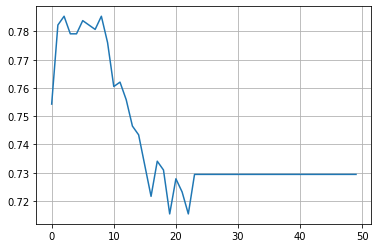

In [14]:
# теперь посмотрим на графике.
pd.Series(tree_test).plot(grid=True)

Интересно что с увеличением гиперпарамтера max_depth больше 10 точность только падает, а после 23 вообще зависает на месте. Те максимальная точность как раз при небольшой глубине расположена и мы ее нашли.

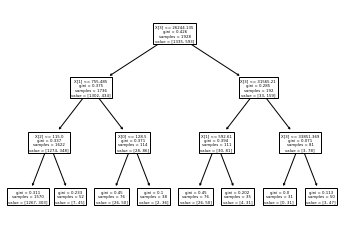

In [15]:
#посомотрим на дерево
tree.plot_tree(model_DecisionTreeClassifier)
plt.show()


**Вывод:** После проведения тестов на валидац выборке получили самую лучшую модель с параметрами:     
Лучшая точность: 0.7853810264385692 при глубине 3
Сохранили ее в **model_DecisionTreeClassifier** .

### RandomForestClassifier  случайный лес

In [16]:
#обучение модели на трениров выборке
model = RandomForestClassifier(random_state=3333)
model.fit(features_train, target_train)

#проверяем модель на валидац выборке
print ('Точность на гиперпараметрах по умолчанию',accuracy_score(target_valid, model.predict(features_valid)))

Точность на гиперпараметрах по умолчанию 0.7931570762052877


Пройдемся циклом по гиперпараметрам n_estimators =i, criterion = j, max_depth=k. Вычислим лучший результат.

In [17]:
%%time
# цикл тройной 

best_accuracy = 0 #счетчик лучшей точности

criterion_list = ['gini', 'entropy'] # перебор критериев
for i in range(1,51):
    for j in criterion_list:
        for k in range(1,11):
            model = RandomForestClassifier(random_state=3333, n_estimators =i, criterion = j, max_depth=k)
            model.fit(features_train, target_train)
            accuracy = accuracy_score(target_valid, model.predict(features_valid))
            
            if best_accuracy < accuracy:
                best_accuracy = accuracy
                n_estimators = i
                criterion = j
                max_depth = k
            model_RandomForestClassifier = model
            
print ('Лучшая точность:', best_accuracy, 'при: n_estimators = ', n_estimators, \
       ', criterion = ', criterion , ',  max_depth = ', max_depth)

Лучшая точность: 0.807153965785381 при: n_estimators =  18 , criterion =  gini ,  max_depth =  7
CPU times: user 1min 32s, sys: 347 ms, total: 1min 32s
Wall time: 1min 34s


Лучшие  результаты при тестах при изменениях различных лимитов циклов.     
Лучшая точность: 0.7931570762052877 при кол-ве деревьев 16 , criterion entropy max_depth 3     
Лучшая точность: 0.807153965785381 при кол-ве деревьев 18 , criterion gini max_depth 7


**Вывод:** После проведения тестов на валидац выборке получили самую лучшую модель с  со следующими характеристиками:     
точность: 0.807153965785381 при n_estimators 18 , criterion gini, max_depth 7.      
Сохранили ее в **model_RandomForestClassifier**.

### LogisticRegression  Логическая регрессия

In [18]:
#обучение модели на трениров выборке
model = LogisticRegression(random_state=3333)
model.fit(features_train, target_train)

#проверяем модель на валидац выборке
print ('Точность на гиперпараметрах по умолчанию',accuracy_score(target_valid, model.predict(features_valid)))

Точность на гиперпараметрах по умолчанию 0.7107309486780715


Логическая регрессия на гиперпараметре по умолчанию похуже, дерева решений и рандомного леса.
Пройдемся циклом по  важному гиперпараметру  max_iter

In [19]:
# цикл
best_accuracy = 0 #счетчик лучшей точности
best_iter = 0    # счетчик кол-ва итераций
log_reg_test = [] # резуьлтаты
for i in range(0,500,10):
    model = LogisticRegression(random_state=3333, max_iter=i )
    model.fit(features_train, target_train)
    accuracy = accuracy_score(target_valid, model.predict(features_valid))
    log_reg_test.append(accuracy)
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        best_iter = i
        model_LogisticRegression = model
print ('Лучшая точность:', best_accuracy, 'при кол-ве итераций' ,best_iter)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучшая точность: 0.7107309486780715 при кол-ве итераций 40


#log_reg_test
Лучшая точность: 0.7107309486780715 при кол-ве итераций 40

<AxesSubplot:>

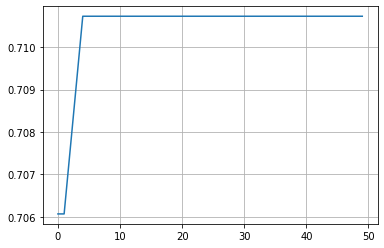

In [ ]:
# теперь посмотрим на графике.
pd.Series(log_reg_test).plot(grid=True)

Тут получили лучший результат так же как при параметрах по умолчанию. на max_iter = 40 выходим на максимальную точность, а дальше  точность не растет.


**Вывод:** После проведения тестов на валидац выборке получили самую лучшую модель с кол-вом итераций = 40.
Сохранили ее в model_LogisticRegression для дальнейшего Сравнения.

Сравним лучших результатов трех моделей.      

DecisionTreeClassifier дерево решений:    
Лучшая точность: 0.7853810264385692 при глубине 3    

RandomForestClassifier случайный лес:      
Лучшая точность: 0.807153965785381 при n_estimators = 18 , criterion = gini, max_depth = 7   

 LogisticRegression Логическая регрессия:     
Лучшая точность: 0.7107309486780715 при кол-ве итераций 40    

**Вывод**  лучший результат у "Леса", будем эту модель применять на тестовой выборке.

## Проверьте модель на тестовой выборке

Проверяем  лучшую модель **model_RandomForestClassifier** на тестовой выборке

In [ ]:
#cлучайный лес
print ('Точность модели случайного леса на тестовой выборке',\
       accuracy_score(target_test, model_RandomForestClassifier.predict(features_test)))

Точность модели случайного леса на тестовой выборке 0.8087091757387247


**Вывод:**     
Модель Случайного леса показала на тестовой выборке даже немного лучший результат  0.8087091757387247     
против 0.807153965785381 на валидационной.  
Считаем результат достигнут. Модель создана и может применяться в бизнес процессах


**Проведем дополнительный Тест:**   
    Объединяем тренировочную выборку и валидационную.   
    Обучаем на ней выбранную модель с выбранными гиперпараметрами.     
    Тестируем на тестовой выборке и сравниваем результат.

In [ ]:
#соеденение тренр и валидц выборок features_valid
features_additional = pd.concat([features_train, features_valid], ignore_index=True)
target_additional = pd.concat([target_train, target_valid], ignore_index=True)
# и проверим размерчики
print ('Размер features_additional: ',features_additional.shape)
print ('Размер target_additional:  ', target_additional.shape)

Размер features_additional:  (2571, 4)
Размер target_additional:   (2571,)


In [ ]:
# обучаем модель  RF  с выбранными гипер параметрами  на объединенной выборке
model_additional = RandomForestClassifier(random_state=3333, n_estimators=18, max_depth = 7)
model_additional.fit(features_additional, target_additional)

RandomForestClassifier(max_depth=7, n_estimators=18, random_state=3333)

In [ ]:
# применяем на тестовой выборке
print ('Точность дополнительной модели RF на тестовой выборке ',\
       accuracy_score(target_test, model_additional.predict(features_test)))

Точность дополнительной модели RF на тестовой выборке  0.80248833592535


**Вывод по доп исследованию** .   
Точность дополнительной модели RF на тестовой выборке  0.80248833592535      
Лучший результат основной модели 0.8087091757387247    

Точность показала немного худжий результат. возможно это в рамках погрешности/случайности, тк размер тестовой выборки не такой большой, чтобы  по настоящему оценить на болшом кол-ве данных.

## Проверка модели на адекватность

Проверим модель на адекватность на тестовой выборке.
1. Пусть все предсказания будут 1
2. Пусть все предсказания будут 0


In [ ]:
#все предсказания 1
print ('точность модели  где все предсказания "1":  ',target_test.mean())
print ('точность модели  где все предсказания "0":  ',1-target_test.mean())

точность модели  где все предсказания "1":   0.3157076205287714
точность модели  где все предсказания "0":   0.6842923794712286


**Вывод**Как видно модель , где предсказания "0", сравнима по точность с логической регрессией.     
Но вот модели дерева и леса, дают бОльшую точность,  в целом эти модели адекватны.

### попробуем устранить/потестировать мультиколлинеарность
 Признаки 'calls' и 'minutes'  сильно коллериуют, дропаем  столбец 'minutes'.  
 Сам датасет был заменен в п 1, а затем перзапущен весь код и записаны результаты , т к это оптимально.   
Получили такие результаты

**модель DT**      
Полный дата сет      
Лучшая точность: 0.7853810264385692 при глубине 3     
Обрезанный дс (дроп 'minutes')       
Лучшая точность: 0.7900466562986003 при глубине 5  

**модель RF**    
Полный дата сет     
Лучшая точность: 0.807153965785381 при кол-ве деревьев 18 , criterion gini max_depth 7   
Обрезанный дс (дроп 'minutes')       
Лучшая точность: 0.7993779160186625 при: n_estimators 13 , criterion gini ,  max_depth 8   

**модель LR**     
Полный дата сет    
Лучшая точность: 0.7107309486780715 при кол-ве итераций 40    
Обрезанный дс (дроп 'minutes')    
Лучшая точность: 0.7091757387247278 при кол-ве итераций 10

Результат улучшился у дерева, потому  что как раз мультиколлиниальность приводит к переобучению. А тут дерево покзало лучший результат уже на большем кол-ве веток 5шт.

##  Общий вывод по проекту:    
Задача спрогнозирвоать для пользователя выбор оптимального тарифа(из двух) исходя из имеющихся данных .
1. Проанализированый исходный дата сет с информацией по тарифу.Дата сет без пропусков и готов к построению моделей.
2. Данные были разделены на обучающию, валидац и тестовые выобрки в отношении 60 / 20 / 20%.
3. На обучающей выборке были обучены модели Дерева , Случайного Леса,и  Логический Регрессии. На Валидационной выборке исследована точной каждой модели изменяя гипер параметры в циклах.    
Найдена самая точная модель :  RandomForestClassifier (случайный лес)  Лучшая точность: 0.807153965785381 при n_estimators = 18 , criterion = gini, max_depth = 7   
4.На тестовой выборке эта модель показала даже немного лучший результат  0.8087091757387247. Модель готва для использования в бизнес процессах.     
Проведен дополнительный тест. Выборка обучающая и валидационная были объеденены. ЗАтем на этой выборке обучена модель с выбранными (лучшими) гиперпараметрами. Модель применена на тестовой выборке. Результат оказался чуть хуже. Поэтому лучшая модель с лучшими результатми осталась прежней.   
5. Проведен анализ на адекватность модели. Модель адекватна. Так же проведен анализ на мультиколлиниальность. Показавший, что добиться повышенной точности модели не удалось.